<style>div.container { width: 100% }</style>
<img style="float:left;  vertical-align:text-bottom;" height="65" width="172" src="../assets/holoviz-logo-unstacked.svg" />
<div style="float:right; vertical-align:text-bottom;"><h2>Tutorial 6. Interlinked Plots</h2></div>

Using hvPlot allows you to generate a number of different types of plot
quickly from a standard API by building [HoloViews](https://holoviews.org) objects, as discussed in the previous
notebook. These objects are rendered with Bokeh which offers a number of
standard ways to interact with your plot, such as panning and zooming
tools.

Many other modes of interactivity are possible when building an
exploratory visualization (such as a dashboard) and these forms of
interactivity cannot be achieved using hvPlot alone.

In this notebook, we will drop down to the HoloViews level of
representation to build a visualization directly that consists of linked plots that
update when you interactivity select a particular earthquake with the
mouse. The goal is to show how more sophisticated forms of interactivity can be built when needed, in a way that's fully compatible with all the examples shown in earlier sections.

First let us load our initial imports:

In [1]:
import numpy as np
import pandas as pd
import dask.dataframe as dd
import hvplot.pandas  # noqa
from datashader.utils import lnglat_to_meters
from holoviews.element import tiles

And clean the data before filtering (for magnitude `>7`) and projecting to to Web Mercator as before:

In [2]:
df = dd.read_parquet('../../../../holoviz-examples/data/earthquakes.parq').repartition(npartitions=4)
cleaned_df = df.copy()
cleaned_df['mag'] = df.mag.where(df.mag > 0)
cleaned_reindexed_df = cleaned_df.set_index(cleaned_df.time)
cleaned_reindexed_df = cleaned_reindexed_df.persist()

most_severe = cleaned_reindexed_df[cleaned_reindexed_df.mag >= 7].compute()
x, y = lnglat_to_meters(most_severe.longitude, most_severe.latitude)
most_severe_projected = most_severe.join([pd.DataFrame({'easting': x}), pd.DataFrame({'northing': y})])

C:\Users\CRTUCKER\Anaconda3\envs\holoviz\lib\site-packages\fastparquet\dataframe.py:5: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import CategoricalIndex, RangeIndex, Index, MultiIndex


Towards the end of the previous notebook we generated a scatter plot of earthquakes
across the earth that had a magnitude `>7` that was projected using 
datashader and overlaid on top of a map tile source:

In [3]:
high_mag_quakes = most_severe_projected.hvplot.points(x='easting', y='northing', c='mag', 
                                                      title='Earthquakes with magnitude >= 7')
esri = tiles.ESRI().redim(x='easting', y='northing')
esri * high_mag_quakes

:Overlay
   .Tiles.I  :Tiles   [easting,northing]
   .Points.I :Points   [easting,northing]   (mag)

And saw how this object is a HoloViews `Points` object:

In [4]:
print(high_mag_quakes)

:Points   [easting,northing]   (mag)


This object is an example of a HoloViews *Element* which is an object that can display itself. These elements are *thin* wrappers around your data and the raw input data is always available on the `.data` attribute. For instance, we can look at the `head` of the `most_severe_projected` `DataFrame` as follows:

In [5]:
high_mag_quakes.data.head()

depth  depthError  dmin  gap  \
time                                                             
2000-01-08 16:47:20.580000+00:00  183.4         NaN   NaN  NaN   
2000-02-25 01:43:58.640000+00:00   33.0         NaN   NaN  NaN   
2000-03-28 11:00:22.510000+00:00  126.5         NaN   NaN  NaN   
2000-04-23 09:27:23.320000+00:00  608.5         NaN   NaN  NaN   
2000-05-04 04:21:16.210000+00:00   26.0         NaN   NaN  NaN   

                                  horizontalError          id  latitude  \
time                                                                      
2000-01-08 16:47:20.580000+00:00              NaN  usp0009kx3   -16.925   
2000-02-25 01:43:58.640000+00:00              NaN  usp0009nxg   -19.528   
2000-03-28 11:00:22.510000+00:00              NaN  usp0009qb4    22.338   
2000-04-23 09:27:23.320000+00:00              NaN  usp0009rrc   -28.307   
2000-05-04 04:21:16.210000+00:00              NaN  usp0009sbh    -1.105   

                                 locationSource  longitude  mag  ...  net  \
time                                                             ...        
2000-01-08 16:47:20.580000+00:00             us   -174.248  7.2  ...   us   
2000-02-25 01:43:58.640000+00:00             us    173.818  7.1  ...   us   
2000-03-28 11:00:22.510000+00:00             us    143.730  7.6  ...   us   
2000-04-23 09:27:23.320000+00:00             us    -62.990  7.0  ...   us   
2000-05-04 04:21:16.210000+00:00             us    123.573  7.6  ...   us   

                                  nst                           place   rms  \
time                                                                          
2000-01-08 16:47:20.580000+00:00  NaN                           Tonga  1.25   
2000-02-25 01:43:58.640000+00:00  NaN                  Vanuatu region  1.20   
2000-03-28 11:00:22.510000+00:00  NaN   Volcano Islands, Japan region  1.22   
2000-04-23 09:27:23.320000+00:00  NaN  Santiago Del Estero, Argentina  0.89   
2000-05-04 04:21:16.210000+00:00  NaN             Sulawesi, Indonesia  1.14   

                                    status                             time  \
time                                                                          
2000-01-08 16:47:20.580000+00:00  reviewed 2000-01-08 16:47:20.580000+00:00   
2000-02-25 01:43:58.640000+00:00  reviewed 2000-02-25 01:43:58.640000+00:00   
2000-03-28 11:00:22.510000+00:00  reviewed 2000-03-28 11:00:22.510000+00:00   
2000-04-23 09:27:23.320000+00:00  reviewed 2000-04-23 09:27:23.320000+00:00   
2000-05-04 04:21:16.210000+00:00  reviewed 2000-05-04 04:21:16.210000+00:00   

                                        type                   updated  \
time                                                                     
2000-01-08 16:47:20.580000+00:00  earthquake  2017-11-07T16:16:22.048Z   
2000-02-25 01:43:58.640000+00:00  earthquake  2017-11-07T16:17:30.218Z   
2000-03-28 11:00:22.510000+00:00  earthquake  2018-10-17T19:37:57.922Z   
2000-04-23 09:27:23.320000+00:00  earthquake  2017-11-07T16:14:17.222Z   
2000-05-04 04:21:16.210000+00:00  earthquake  2018-10-17T19:38:07.682Z   

                                       easting      northing  
time                                                          
2000-01-08 16:47:20.580000+00:00 -1.939720e+07 -1.912096e+06  
2000-02-25 01:43:58.640000+00:00  1.934933e+07 -2.217199e+06  
2000-03-28 11:00:22.510000+00:00  1.599995e+07  2.552155e+06  
2000-04-23 09:27:23.320000+00:00 -7.012015e+06 -3.287735e+06  
2000-05-04 04:21:16.210000+00:00  1.375608e+07 -1.230157e+05  

[5 rows x 24 columns]

We will now learn a little more about `HoloViews` elements, including how to build them up from scratch so that we can control every aspect of them.

### An Introduction to HoloViews Elements

HoloViews elements are the atomic, visualizable components that can be
rendered by a plotting library such as Bokeh. We don't actually need to use
hvPlot to create these element objects: we can create them directly by
importing HoloViews (and loading the extension if we have not loaded
hvPlot):

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
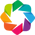

In [6]:
import holoviews as hv
hv.extension("bokeh") # Optional here as we have already loaded hvplot.pandas

Now we can create our own example of a `Points` element. In the next
cell we plot 100 points with a normal (independent) distrbutions in the
`x` and `y` directions:

In [7]:
xs = np.random.randn(100)
ys = np.random.randn(100)
hv.Points((xs, ys))

:Points   [x,y]

Now that the axis labels are 'x' and 'y', the default *dimensions* for
this element type. We can use a different set of dimensions along the x- and y-axis (say
'weight' and 'height') and we can also associate additional `fitness` information with each point if we wish:

In [8]:
xs = np.random.randn(100)
ys = np.random.randn(100)
fitness = np.random.randn(100)
height_v_weight = hv.Points((xs, ys, fitness), ['weight', 'height'], 'fitness')
height_v_weight

:Points   [weight,height]   (fitness)

Now we can look at the printed representation of this object:

In [9]:
print(height_v_weight)

:Points   [weight,height]   (fitness)


Here the printed representation shows the *key dimensions* that we specified in square brackets as `[weight,height]` and the additional *value dimension* `fitness` in parentheses as `(fitness)`. The *key dimensions* map to the axes and the *value dimensions* can be visually represented by other visual attributes as we shall see shortly.

For more information an HoloViews dimensions, see this [user guide](http://holoviews.org/user_guide/Annotating_Data.html).

#### Exercise

Visit the [HoloViews reference gallery](http://holoviews.org/reference/index.html) and browse
the available set of elements. Pick an element type and try running
one of the self-contained examples in the following cell.

In [10]:
xvals = np.linspace(0,4,202)
ys,xs = np.meshgrid(xvals, -xvals[::-1])
hv.Raster(np.sin(((ys)**3)*xs))

:Raster   [x,y]   (z)

### Setting Visual Options

The two `Points` elements above look quite different from the one
returned by hvplot showing the earthquake positions. This is because
hvplot makes use of the HoloViews *options system* to customize the
visual representation of these element objects.

Let us color the `height_v_weight` scatter by the fitness value and use a larger
point size:

In [11]:
height_v_weight.opts(color='fitness', size=8, colorbar=True, aspect='square')

:Points   [weight,height]   (fitness)

#### Exercise

Copy the line above into the next cell and try changing the points to
'blue' or 'green' or another dimension of the data  such as 'height' or 'weight'.

Are the results what you expect?

In [25]:
height_v_weight.opts(color='fitness', size=8, colorbar=True, aspect='square', cmap='greens', tools=['hover'])

:Points   [weight,height]   (fitness)

### The `help` system

You can learn more about the `.opts` method and the HoloViews options
system in the [corresponding user
guide](http://holoviews.org/user_guide/Applying_Customizations.html). To
easily learn about the available options from inside a notebook, you can
use `hv.help` and inspect the 'Style Options'.

In [ ]:
# Commented as there is a lot of help output!
# hv.help(hv.Scatter) 

At this point, we can have some insight to the sort of HoloViews object
hvPlot is building behind the scenes for our earthquake example:

In [18]:
esri * hv.Points(most_severe_projected, ['easting', 'northing'], 'mag').opts(color='mag', size=8, aspect='equal')

:Overlay
   .Tiles.I  :Tiles   [easting,northing]
   .Points.I :Points   [easting,northing]   (mag)

#### Exercise

Try using `hv.help` to inspect the options available for different element types such as the `Points` element used above. Copy the line above into the cell below and pick a `Points` option that makes sense to you and try using it in the `.opts` method.

<details><summary>Hint</summary><br>

If you can't decide on an option to pick, a good choice is `marker`. For instance, try:

 * `marker='+'` 
 * `marker='d'`.
 
 HoloViews uses [matplotlib's conventions](https://matplotlib.org/3.1.0/api/markers_api.html) for specifying the various marker types. Try finding out which ones are support by Bokeh.

</details>

### Custom interactivity for Elements

When rasterization of the population density data via hvplot was
introduced in the last notebook, we saw that the HoloViews object
returned was not an element but a *`DynamicMap`*.

A `DynamicMap` enables custom interactivity beyond the Bokeh defaults by
dynamically generating elements that get displayed and updated as the
plot is interacted with.

There is a counterpart to the `DynamicMap` that does not require a live
Python server to be running called the `HoloMap`. The `HoloMap`
container will not be covered in the tutorial but you can learn more
about them in the [containers user
guide](http://holoviews.org/user_guide/Dimensioned_Containers.html).

Now let us build a very simple `DynamicMap` that is driven by a *linked
stream* (specifically a `PointerXY` stream) that represents the position
of the cursor over the plot:

In [19]:
from holoviews import streams

ellipse = hv.Ellipse(0, 0, 1) 
pointer = streams.PointerXY(x=0, y=0) # x=0 and y=0 are the initialized values

def crosshair(x, y):
    return hv.HLine(y) * hv.VLine(x)

ellipse * hv.DynamicMap(crosshair, streams=[pointer])

:DynamicMap   []
   :Overlay
      .Ellipse.I :Ellipse   [x,y]
      .HLine.I   :HLine   [x,y]
      .VLine.I   :VLine   [x,y]

Try moving your mouse over the plot and you should see the crosshair
follow your mouse position.

The core concepts here are:

* The plot shows an overlay built with the `*` operator introduced in
  the previous notebook.
* There is a callback that returns this overlay that is built according
  to the supplied `x` and `y` arguments. A DynamicMap always contains a
  callback that returns a HoloViews object such as an `Element` or
  `Overlay`
* These `x` and `y` arguments are supplied by the `PointerXY` stream
  that reflect the position of the mouse on the plot.

#### Exercise

Look up the `Ellipse`, `HLine`, and `VLine` elements in the
[HoloViews reference guide](http://holoviews.org/reference/index.html) and see
if the definitions of these elements align with your initial intuitions.

#### Exercise (additional)

If you have time, try running one of the examples in the
'Streams' section of the [HoloViews reference guide](http://holoviews.org/reference/index.html) in the cell below. All the examples in the reference guide should be relatively short and self-contained.

### Selecting a particular earthquake with the mouse

Now we only need two more concepts before we can set up the appropriate
mechanism to select a particular earthquake on the hvPlot-generated
Scatter plot we started with.

First, we can attach a stream to an existing HoloViews element such as
the earthquake distribution generated with hvplot:

In [20]:
selection_stream = streams.Selection1D(source=high_mag_quakes)

Next we need to enable the 'tap' tool on our Scatter to instruct Bokeh
to enable the desired selection mechanism in the browser.

In [21]:
high_mag_quakes.opts(tools=['tap'])

:Points   [easting,northing]   (mag)

The Bokeh default alpha of points which are unselected is going to be too low when we overlay these points on a tile source. We can use the HoloViews options system to pick a better default as follows:

In [26]:
hv.opts.defaults(hv.opts.Points(nonselection_alpha=0.4))

The tap tool is in the toolbar with the icon showing the concentric
circles and plus symbol. If you enable this tool, you should be able to pick individual earthquakes above by tapping on them.

Now we can make a DynamicMap that uses the stream we defined to show the index of the earthquake selected via the `hv.Text` element:

In [27]:
def labelled_callback(index):
    if len(index) == 0:
        return  hv.Text(x=0,y=0, text='')
    first_index = index[0] # Pick only the first one if multiple are selected
    row = most_severe_projected.iloc[first_index]
    text = '%d : %s' % (first_index, row.place)
    return hv.Text(x=row.easting, y=row.northing, text=text).opts(color='white')

labeller = hv.DynamicMap(labelled_callback, streams=[selection_stream])

This labeller receives the index argument from the Selection1D stream
which corresponds to the row of the original dataframe (`most_severe`)
that was selected. This lets us present the index and place value using
`hv.Text` which we then position at the corresponding latitude and
longitude to label the chosen earthquake.

Finally, we overlay this labeller `DynamicMap` over the original
plot. Now by using the tap tool you can see the index number of an
earthquake followed by the assigned place name:

In [28]:
(esri * high_mag_quakes * labeller).opts(hv.opts.Points(tools=['tap', 'hover']))

:DynamicMap   []
   :Overlay
      .Tiles.I  :Tiles   [easting,northing]
      .Points.I :Points   [easting,northing]   (mag)
      .Text.I   :Text   [x,y]

#### Exercise

Pick an earthquake point above and using the displayed index, display the corresponding row of the `most_severe` dataframe using the `.iloc` method in the following cell.

### Building a linked earthquake visualizer

Now we will build a visualization that achieves the following:

* The user can select an earthquake with magnitude `>7` using the tap
  tool in the manner illustrated in the last section.
  
* In addition to the existing label, we will add concentric circles to further highlight the
  selected earthquake location.

* *All* earthquakes within 0.5 degrees of latitude and longitude of the
   selected earthquake (~50km) will then be used to supply data for two linked
   plots:
   
   1. A  histogram showing the distribution of magnitudes in the selected area.
   2. A timeseries scatter plot showing the magnitudes of earthquakes over time in the selected area.

The first step is to generate a concentric-circle marker using a similar approach to the `labeller` above. We can write a function that uses `Ellipse` to mark a particular earthquake and pass it to a `DynamicMap`:

In [29]:
def mark_earthquake(index):
    if len(index) == 0:
        return  hv.Overlay([])
    first_index = index[0] # Pick only the first one if multiple are selected
    row = most_severe_projected.iloc[first_index]
    return (hv.Ellipse(row.easting, row.northing, 1.5e6) *
            hv.Ellipse(row.easting, row.northing, 3e6)).opts(
        hv.opts.Ellipse(color='white', alpha=0.5)
    )

quake_marker = hv.DynamicMap(mark_earthquake, streams=[selection_stream])

Now we can test this component by building an overlay of the `ESRI` tile source, the `>=7` magnitude points and `quake_marked`:

In [30]:
esri * high_mag_quakes.opts(tools=['tap']) * quake_marker

:DynamicMap   []
   :Overlay
      .Tiles.I  :Tiles   [easting,northing]
      .Points.I :Points   [easting,northing]   (mag)

Note that you may need to zoom in to your selected earthquake to see the
localized, lower magnitude earthquakes around it.

### Filtering earthquakes by location

We wish to analyse the earthquakes that occur around a particular latitude and longitude. To do this we will define a function that given a latitude and longitude, returns the rows of a suitable dataframe that corresponding to earthquakes within 0.5 degrees of that position:

In [31]:
def earthquakes_around_point(df, lat, lon, degrees_dist=0.5):
    half_dist = degrees_dist / 2.0
    return df[((df['latitude'] - lat).abs() < half_dist) 
              & ((df['longitude'] - lon).abs() < half_dist)].compute()

As it can be slow to filter our dataframes in this way, we can define the following function that can cache the result of filtering `cleaned_reindexed_df` (containing all earthquakes) based on an index pulled from the `most_severe` dataframe:

In [32]:
def index_to_selection(indices, cache={}):
    if not indices: 
        return most_severe.iloc[[]]
    index = indices[0]   # Pick only the first one if multiple are selected
    if index in cache: return cache[index]
    row = most_severe.iloc[index]
    selected_df = earthquakes_around_point(cleaned_reindexed_df, row.latitude, row.longitude)
    cache[index] = selected_df
    return selected_df 

The caching will be useful as we know both of our planned linked plots (i.e the histogram and scatter over time) make use of the same earthquake selection once a particular index is supplied from a user selection. This particular caching strategy is rather awkward (and leaks memory!) but it simple and will serve for the current example. A better approach to caching will be presented in the [Advanced Dashboards](./08_Advanced_Dashboards.ipynb) section of the tutorial.

#### Exercise

Test the `index_to_selection` function above for the index you picked in the previous exercise. Note that the stream supplied a *list* of indices and that the function above only uses the first value given in that list. Do the selected rows look correct?:

#### Exercise

Convince yourself that the selected earthquakes are within 0.5$^o$ distance of each other in both latitude and longitude.

<details><summary>Hint</summary><br>

For a given `chosen` index, you can see the distance difference using the following code:

```python
chosen = 235
delta_long = index_to_selection([chosen]).longitude.max() - index_to_selection([chosen]).longitude.min()
delta_lat = index_to_selection([chosen]).latitude.max() - index_to_selection([chosen]).latitude.min()
print("Difference in longitude: %s" % delta_long)
print("Difference in latitude: %s" % delta_lat)
```

</details>

### Linked plots

So far we have overlayed the display updates on top of the existing
spatial distribution of earthquakes. However, there is no requirement
that the data is overlaid and we might want to simply attach an entirely
new, derived plot that dynamically updates to the side.

Using the same principles as we have already seen, we can define a
`DynamicMap` that returns `Histogram` distributions of earthquake
magnitude:

In [33]:
def histogram_callback(index):
    title = 'Distribution of all magnitudes within half a degree of selection'
    selected_df = index_to_selection(index)
    return selected_df.hvplot.hist(y='mag', bin_range=(0,10), bins=20, color='red', title=title)

histogram = hv.DynamicMap(histogram_callback, streams=[selection_stream])

The only real difference in the approach here is that we can still use
`.hvplot` to generate our elements instead of declaring the HoloViews
elements explicitly. In this example, `.hvplot.hist` is used.

The exact same principles can be used to build the scatter callback and `temporal_distribution` `DynamicMap`:

In [34]:
def scatter_callback(index):
    title = 'Temporal distribution of all magnitudes within half a degree of selection '
    selected_df = index_to_selection(index)
    return selected_df.hvplot.scatter('time', 'mag', color='green', title=title)

temporal_distribution = hv.DynamicMap(scatter_callback, streams=[selection_stream])

Lastly, let us define a `DynamicMap` that draws a `VLine` to mark the time at which the selected earthquake occurs so we can see which tremors may have been aftershocks immediately after that major earthquake occurred:

In [35]:
def vline_callback(index):
    if not index:
        return hv.VLine(0).opts(alpha=0)
    row = most_severe.iloc[index[0]]
    return hv.VLine(row.time).opts(line_width=2, color='black')

temporal_vline = hv.DynamicMap(vline_callback, streams=[selection_stream])

We now have all the pieces we need to build an interactive, linked visualization of earthquake data.

#### Exercise

Test the `histogram_callback` and `scatter_callback` callback functions by supplying your chosen index, remembering that these functions require a list argument in the following cell.

### Putting it together

Now we can combine the components we have already built as follows to create a dynamically updating plot together with an associated, linked histogram:

In [36]:
((esri * high_mag_quakes.opts(tools=['tap']) * labeller * quake_marker)
 + histogram + temporal_distribution * temporal_vline).cols(1)

:Layout
   .DynamicMap.I   :DynamicMap   []
      :Overlay
         .Tiles.I  :Tiles   [easting,northing]
         .Points.I :Points   [easting,northing]   (mag)
         .Text.I   :Text   [x,y]
   .DynamicMap.II  :DynamicMap   []
      :Histogram   [mag]   (mag_count)
   .DynamicMap.III :DynamicMap   []
      :Overlay
         .Scatter.I :Scatter   [time]   (mag)
         .VLine.I   :VLine   [x,y]

We now have a custom interactive visualization that builds on the output of `hvplot` by making use of the underlying HoloViews objects that it generates.

## Conclusion

When exploring data it can be convenient to use the `.plot` API to quickly visualize a particular dataset. By calling `.plot` to generate different plots over the course of a session, it is possible to gradually build up a mental model of how a particular dataset is structured. While this works well for simple datasets, it can be more efficient to build a linked visualization with support for direct user interaction as a tool for more rapidly gaining insight.

In the workflow presented here, building such custom interaction is relatively quick and easy and does not involve throwing away prior code used to generate simpler plots. In the spirit of 'short cuts not dead ends', we can use the HoloViews output of `hvplot` that we used in our initial exploration to build rich visualizations with custom interaction to explore our data at a deeper level. 

These interactive visualizations not only allow for custom interactions beyond the scope of `hvplot` alone, but they can display visual annotations not offered by the `.plot` API. In particular, we can overlay our data on top of tile sources, generate interactive textual annotations, draw shapes such a circles, mark horizontal and vertical marker lines and much more. Using HoloViews you can build visualizations that allow you to directly interact with your data in a useful and intuitive manner.

In this notebook, the earthquakes plotted were either filtered early on by magnitude (`>=7`) or dynamically to analyse only the earthquakes within a small geographic distance. This allowed us to use Bokeh directly without any special handing and without having to worry about the performance issues that would be occur if we were to try to render the whole dataset at once.

In the next section we will see how such large datasets can be visualized directly using Datashader.